In [15]:
# this was all done in vscode connected to fe server
import os
import cv2
import pickle
import random
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin, medial_axis

from collections import Counter
from tqdm import tqdm

cwd = os.getcwd()
data_dir = "/home/steffenm/data/cv/dataset"
dataset_dir = os.path.join(data_dir, "dataset")

class_names = os.listdir(dataset_dir)

images = []
labels = []

# map class names to integers
class_names_map = {class_name: i for i, class_name in enumerate(class_names)}
print(class_names_map)
pickle.dump(class_names_map, open(os.path.join(data_dir, "class_names_map.pkl"), "wb"))

for class_name, class_id in tqdm(class_names_map.items()):
    class_dir = os.path.join(dataset_dir, class_name)

    for filename in os.listdir(class_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(class_dir, filename)
            
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            
            images.append(image)
            labels.append(class_id)

# Save the dataset to a pickle file
dataset = {
    'images': images,
    'labels': labels
}
print("DATASET LABELS:",set(labels))
df = pd.DataFrame(dataset)

pickle.dump(dataset, open(os.path.join(data_dir, "dataset.pkl"), "wb"))


{'times': 0, 'f': 1, 'e': 2, 'tan': 3, '(': 4, '6': 5, 'y': 6, '-': 7, '2': 8, 'div': 9, '7': 10, '8': 11, ')': 12, 'sum': 13, '4': 14, ',': 15, 'sqrt': 16, '=': 17, '0': 18, 'sin': 19, '3': 20, '+': 21, '1': 22, 'cos': 23, '9': 24, 'pi': 25, '5': 26}


100%|██████████| 27/27 [00:09<00:00,  2.84it/s]


DATASET LABELS: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


In [16]:
data_dir = "/home/steffenm/data/cv/dataset"

dataset = pickle.load(open(os.path.join(data_dir, "dataset.pkl"), "rb"))

images = dataset['images']
labels = dataset['labels']
print(set(labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


17


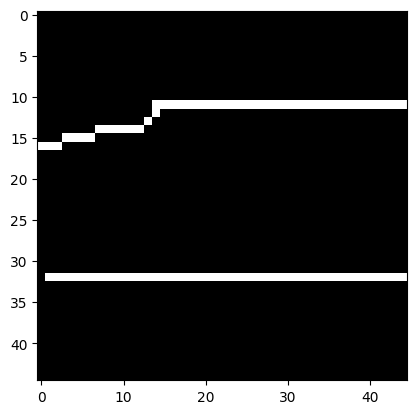

22


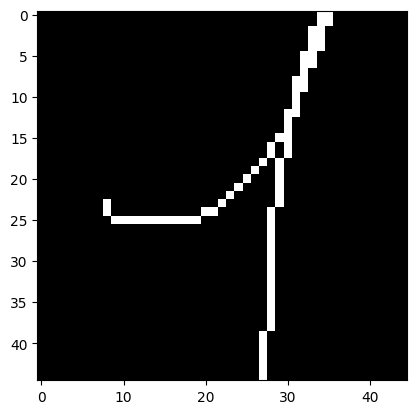

17


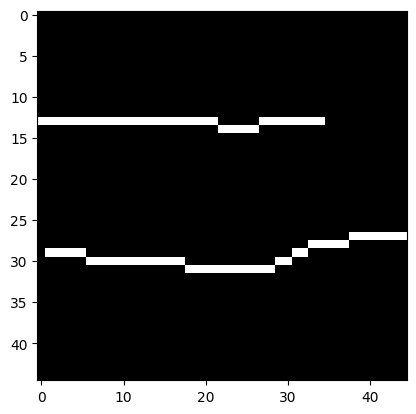

In [24]:

# print random images
for i in random.sample(range(len(images)), 3):
    print(labels[i])
    plt.imshow(images[i],cmap='gray')
    plt.show()

In [18]:
# balance dataset to 5000 images per class

data_dir = "/home/steffenm/data/cv/dataset"

dataset = pickle.load(open(os.path.join(data_dir, "dataset.pkl"), "rb"))

images = dataset['images']
labels = dataset['labels']
print(set(labels))

class_counts = Counter(labels)
print(class_counts)

target_count = 5000

balanced_images = []
balanced_labels = []

for class_name in tqdm(class_counts.keys()):
    # Get the number of images with the current class
    class_indices = [i for i, label in enumerate(labels) if label == class_name]
    class_count = len(class_indices)

    if class_count > target_count:
        images_to_keep_indices = np.random.choice(class_indices, target_count)

        balanced_images.extend([images[i] for i in images_to_keep_indices])
        balanced_labels.extend([class_name] * target_count)
    else:  
        balanced_images.extend([images[i] for i in class_indices])
        balanced_labels.extend([class_name] * class_count)

# Save the balanced dataset
balanced_dataset = {
    'images': balanced_images,
    'labels': balanced_labels
}
pickle.dump(balanced_dataset, open(os.path.join(data_dir, "balanced_dataset.pkl"), "wb"))

# Count the number of images per class
balanced_class_counts = Counter(balanced_labels)
print(balanced_class_counts)


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Counter({7: 33997, 22: 26520, 8: 26141, 21: 25112, 12: 14355, 4: 14294, 17: 13104, 20: 10909, 6: 9340, 16: 8908, 14: 7396, 18: 6914, 19: 4293, 24: 3737, 1: 3712, 26: 3545, 0: 3251, 5: 3118, 11: 3068, 2: 3003, 23: 2986, 10: 2909, 13: 2689, 3: 2450, 25: 2332, 15: 1906, 9: 868})


100%|██████████| 27/27 [00:00<00:00, 77.49it/s]


Counter({4: 5000, 6: 5000, 7: 5000, 8: 5000, 12: 5000, 14: 5000, 16: 5000, 17: 5000, 18: 5000, 20: 5000, 21: 5000, 22: 5000, 19: 4293, 24: 3737, 1: 3712, 26: 3545, 0: 3251, 5: 3118, 11: 3068, 2: 3003, 23: 2986, 10: 2909, 13: 2689, 3: 2450, 25: 2332, 15: 1906, 9: 868})


In [19]:
# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

data_dir = "/home/steffenm/data/cv/dataset"

balanced_dataset = pickle.load(open(os.path.join(data_dir, "balanced_dataset.pkl"), "rb"))

images = balanced_dataset['images']
labels = balanced_dataset['labels']

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Save the training and validation sets
train_dataset = {
    'images': train_images,
    'labels': train_labels
}

val_dataset = {
    'images': val_images,
    'labels': val_labels
}

pickle.dump(train_dataset, open(os.path.join(data_dir, "train_dataset.pkl"), "wb"))
pickle.dump(val_dataset, open(os.path.join(data_dir, "val_dataset.pkl"), "wb"))
